In [218]:
import pugna.layers

In [219]:
import pugna.activations

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

mpl.rcParams.update({"font.size": 16})

In [65]:
def plot_history(history, labels):
    plt.figure()
    for i, h in enumerate(history):
        loss = h.history["loss"]
        plt.plot(range(len(loss)), loss, label=labels[i])
    plt.yscale("log")
    plt.title('train')    
    plt.legend(bbox_to_anchor=(1.05, 1))
    
    if "val_loss"  in history[0].history.keys():
        plt.figure()
        for h in history:
            loss = h.history["val_loss"]
            plt.plot(range(len(loss)), loss, ls='--')
        plt.yscale("log")
        plt.title('validation')

# generate train, test data

In [134]:
# equation 29 of 1910.11710
def gen_test_data(npts=100, nscale=0):
    # x = np.linspace(-np.pi/2., np.pi/2., 100)
    # y = np.cos(10*x) + np.sin(5*x)
    x = np.linspace(-1, 1, npts)
    y = np.cos(50*x) + np.sin(5*x)

    n = np.random.normal(0, scale=nscale, size=y.shape)

    return x[:,np.newaxis], (y+n)[:,np.newaxis]

In [165]:
x, y = gen_test_data(npts=500, nscale=0.2)

In [166]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25)

In [167]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(375, 1)
(125, 1)
(375, 1)
(125, 1)


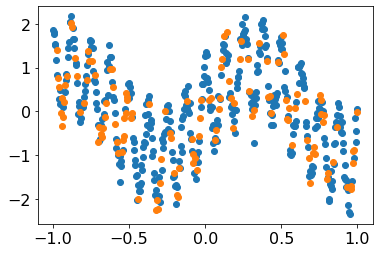

In [168]:
plt.figure()
plt.scatter(x_train, y_train)
plt.scatter(x_test, y_test)

# setup ANN

In [169]:
# https://datascience.stackexchange.com/questions/58884/how-to-create-custom-activation-functions-in-keras-tensorflow
from tensorflow.keras.utils import get_custom_objects
get_custom_objects().update({'srelu': tf.keras.layers.Activation(pugna.activations.sReLU)})
get_custom_objects().update({'s2relu': tf.keras.layers.Activation(pugna.activations.s2relu)})

In [209]:
def build_and_fit_model(
    x,
    y,
    verbose=False,
    batch_size=None,
    nscales=1,
    epochs=1000,
    units=300,
    lr=0.001,
    activation='srelu',
    validation_data=None
):
    if batch_size is None:
        batch_size = x.shape[0]

    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.InputLayer(input_shape=(1,)))
    model.add(pugna.layers.Mscale(units, nscales))
    if activation == 'srelu':
        model.add(tf.keras.layers.Activation(pugna.activations.sReLU))
    elif activation == 's2relu':
        model.add(tf.keras.layers.Activation(pugna.activations.s2relu))
    elif activation == 'relu':
        model.add(tf.keras.layers.Activation(tf.keras.activations.relu))
    elif activation == 'tanh':
        model.add(tf.keras.layers.Activation(tf.keras.activations.tanh))

    model.add(tf.keras.layers.Dense(units, activation=activation))
    model.add(tf.keras.layers.Dense(units, activation=activation))
    model.add(tf.keras.layers.Dense(units, activation=activation))
    model.add(tf.keras.layers.Dense(units, activation=activation))
    model.add(tf.keras.layers.Dense(1, activation="linear"))

    # optimizer = tf.keras.optimizers.Adam(lr)
    optimizer = tf.keras.optimizers.Adam(lr, amsgrad=True)
    #optimizer = tf.keras.optimizers.Adam(lr, amsgrad=True, clipnorm=0.5)
    #optimizer = tf.keras.optimizers.Adam(lr, amsgrad=True, clipvalue=5.0)
    #optimizer = tf.keras.optimizers.Nadam(lr)
    # optimizer = tf.keras.optimizers.SGD(lr)
    model.compile(loss="mse", optimizer=optimizer)

    history = model.fit(x, y, batch_size=batch_size, epochs=epochs, verbose=verbose, validation_data=validation_data)

    return history, model

In [210]:
%%time
history1, model1 = build_and_fit_model(x_train, y_train, epochs=3000, activation='srelu', validation_data=(x_test, y_test))

CPU times: user 2min 34s, sys: 27.9 s, total: 3min 2s
Wall time: 1min 29s


In [211]:
%%time
history2, model2 = build_and_fit_model(x_train, y_train, nscales=50, epochs=3000, activation='srelu', validation_data=(x_test, y_test))

CPU times: user 2min 35s, sys: 28 s, total: 3min 3s
Wall time: 1min 30s


In [212]:
%%time
history3, model3 = build_and_fit_model(x_train, y_train, nscales=50, epochs=3000, activation='s2relu', validation_data=(x_test, y_test))

CPU times: user 2min 54s, sys: 56.8 s, total: 3min 51s
Wall time: 1min 39s


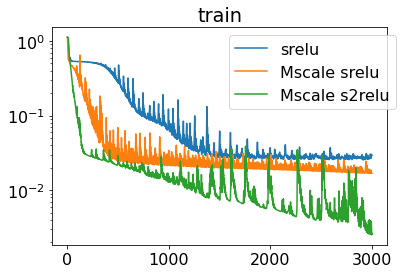

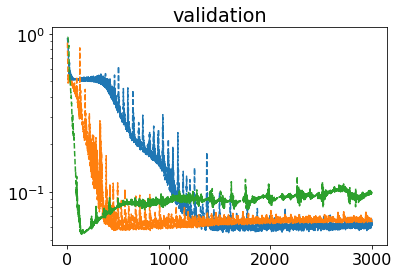

In [213]:
plot_history([history1, history2, history3], labels=['srelu', 'Mscale srelu', 'Mscale s2relu'])

In [214]:
yhat1 = model1.predict(x_train)
yhat2 = model2.predict(x_train)
yhat3 = model3.predict(x_train)

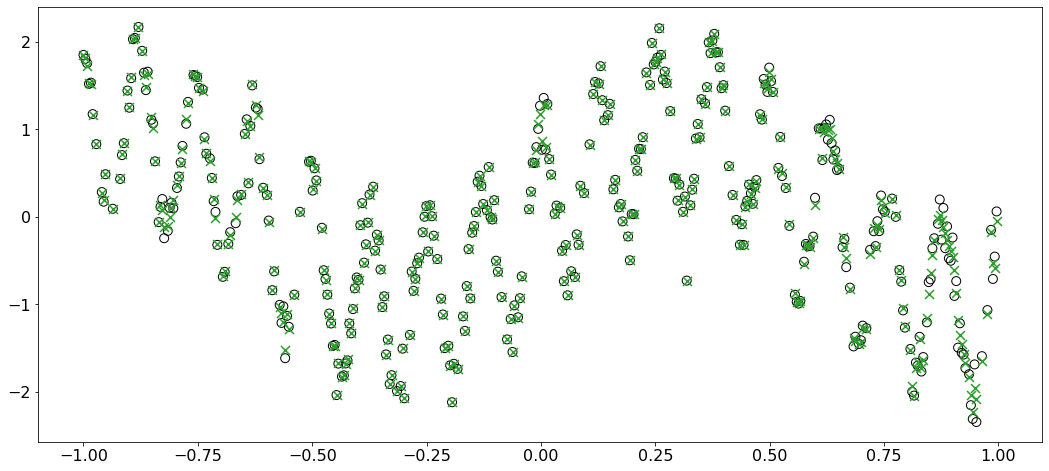

In [215]:
plt.figure(figsize=(18, 8))
plt.scatter(x_train, y_train, facecolors='none', edgecolors='k', s=80)
# plt.scatter(x_train, yhat1, facecolors='none', edgecolors='C0', s=80)
# plt.scatter(x_train, yhat2, facecolors='none', edgecolors='C1', s=80)
plt.scatter(x_train, yhat3, c='C2', marker='x', s=80)

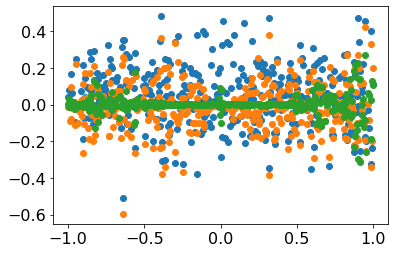

In [216]:
plt.figure()
plt.scatter(x_train, y_train-yhat1)
plt.scatter(x_train, y_train-yhat2)
plt.scatter(x_train, y_train-yhat3)

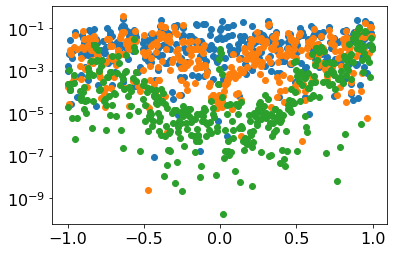

In [217]:
plt.figure()
plt.scatter(x_train, tf.keras.losses.mse(y_train, yhat1))
plt.scatter(x_train, tf.keras.losses.mse(y_train, yhat2))
plt.scatter(x_train, tf.keras.losses.mse(y_train, yhat3))
plt.yscale('log')